# Bank Marketing EDA

By: Joe Sellett (SMU ID), Haiyan Cai (SMU ID), and Cole Wagner (SMU ID)

## Business Understanding

### Data Overview

This dataset is from a Portuguese financial institution and aims to determine whether potential customers will enter into a term deposit with the bank based on a number of factors. The data was collected through direct marketing phone calls with potential customers, and includes demographic information (customer age, job, marital status, etc.), call-specific factors (call duration, outcome of previous marketing campaign, days since last contacted, etc.), and details regarding all loans and credit in default the customer might have (UC Irvine). The outcome variable is binary and describes whether or not the customer subscribed to the term deposit.

### Third-Party Utility

This data is highly valuable information for this institution as well as any other financial institutions across the globe. For example, banks can use this information to identify high-potential customers and allocate their marketing resources more effectively. By employing a data-driven approach to marketing their products, banks can spend less time and money and achieve better overall results by targeting only the customers who are most likely to subscribe to their product.

### Performance Benchmark

This dataset was first analyzed by Sérgio Moro, Paulo Cortez, and Paulo Rita in the *Decision Support Systems* journal. They attempted four modeling approaches (logistic regression, decision trees, neural networks, and support vector machines), and were able to achieve an AUC of 0.8 with a neural network. Since then, this dataset has become very popular and many people have attempted to improve upone the original authors' modeling approach. On Kaggle, Henrique Yamahata was able to achieve an AUC of 0.94 using XGBoost. Given that this is the best-performing model we could find using this dataset, we believe that our model would need to have an AUC of > 0.94 to be useful to third-parties.

In [310]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as mn
import seaborn as sns
import umap
import plotly.graph_objects as go

from sklearn.impute import KNNImputer

In [311]:
bank_data = pd.read_csv("bank-full.csv", delimiter=";")

## Data Description

In [312]:
bank_data.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

**age: int64**
- The age of the potential customer. Ranges from 18 to 95 years old.

**job: object**
- The potential customer's job category. There are 12 total categories of jobs, one of which is "unknown", which we will treat as missing.

**marital: object**
- The potential customer's marital status. This can be "married", "single", or "divorced".

**education: object**
- The education level of the potential customer. The categories for this variable are "secondary", "tertiary", "primary", or "unknown" (which will be treated as missing).

**default: object**
- A binary variable that describes whether or not the potential customer has credit in default. The two factor levels for this variable are "yes" and "no".

**balance: int64**
- The potential customer's average yearly credit balance.

**housing: object**
- Whether or not the potential customer has a housing loan. This can only be "yes" or "no".

**loan: object**
- Whether or not the potential customer has a personal loan. This can only be "yes" or "no".

**contact: object**
- The mode of communication that the potential customer was reached by. This can be "cellular" for mobile phone, "telephone" for home phone, or "unknown", which we will treat as missing.

**day: int64**
- The day of the month of the last contact with the potential customer. These are discrete integer values between 1 and 31.

**month: object**
- The last month in which the potential customer was contacted.

**duration: int64**
- The duration of the last phone call with the potential customer, in seconds. It is important to note that this feature is highly related to the outcome because when duration = 0 then y = "no". Additionally, the duration of the call cannot be known before the call occurs. As a result, this variable should be removed before any modeling takes place.

**campaign: int64**
- The number of phone calls made to the potential customer during this specfic campaign. This ranges from 1 to 44.

**pdays: int64**
- The number of days passed after the potential customer was contacted from a previous campaign. This variable is set to -1 for those who were not previously contacted.

**previous: int64**
- The number of phone calls made to a given potential customer before the current campaign. This variable is set to 0 for those who were not previously contacted.

**poutcome: object**
- The outcome of the previous marketing campaign for this particular customer. This variable can be "failure", "other", "success", or "unknown", which will be treated as missing.

**y: object**
- Whether or not the customer subscribed to a term deposit. This is the outcome variable, and can only be "yes" or "no".

## Data Quality

### Duplicate Data

In [313]:
sum(bank_data.duplicated())

0

The above code shows that there are no duplicate rows in our data. The duplicated() function returns a boolean series, and the sum function adds up all the boolean values as True=1 and False=0. Because the sum of the series is 0, we know that there are no duplicates. As a result, no rows need to be removed due to duplication.

### Missing Data

In [314]:
bank_data.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

The above code shows that are data has no null values. However, this does not mean that we have no missing data, as missing data can be "unknown" in categorical variables.

In [315]:
cat_vars = ["job", "marital", "education",
            "default", "housing", "loan",
            "contact", "day", "month",
           "poutcome"]

for x in cat_vars:
    print(bank_data[x].value_counts())

job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: count, dtype: int64
marital
married     27214
single      12790
divorced     5207
Name: count, dtype: int64
education
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: count, dtype: int64
default
no     44396
yes      815
Name: count, dtype: int64
housing
yes    25130
no     20081
Name: count, dtype: int64
loan
no     37967
yes     7244
Name: count, dtype: int64
contact
cellular     29285
unknown      13020
telephone     2906
Name: count, dtype: int64
day
20    2752
18    2308
21    2026
17    1939
6     1932
5     1910
14    1848
8     1842
28    1830
7     1817
19    1757
29    1745
15    1703
12    1603
13    1585
30    1566
9     1561
11    1479
4     1445
16    1415
2     1293
27 

From the above output, we can see that "job", "education", "contact", and "poutcome" all have "unknown" values. These will either need to be imputed or removed from the data.

In [316]:
# Convert all "unknown" values to null
df = bank_data.replace("unknown", np.nan)

In [317]:
df.isnull().sum()

age              0
job            288
marital          0
education     1857
default          0
balance          0
housing          0
loan             0
contact      13020
day              0
month            0
duration         0
campaign         0
pdays            0
previous         0
poutcome     36959
y                0
dtype: int64

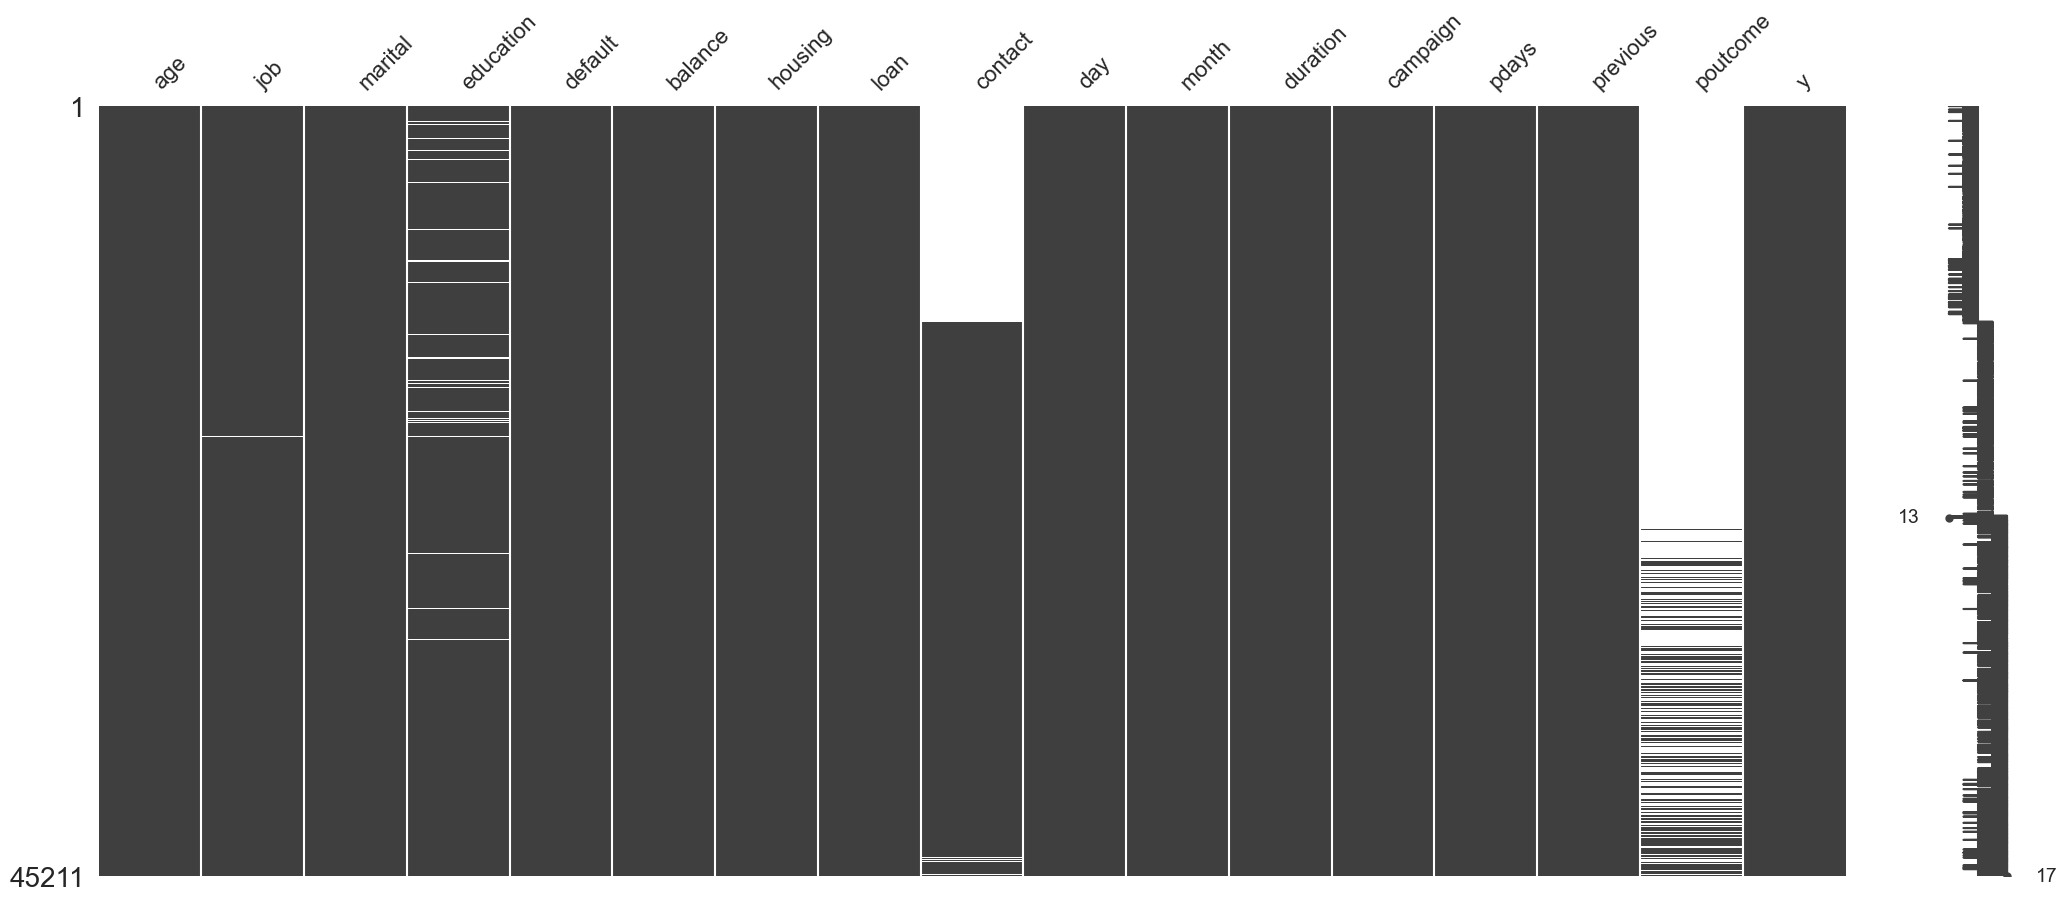

<Figure size 640x480 with 0 Axes>

In [318]:
# Plot missing values
mn.matrix(df) 
plt.figure()
plt.show()

### Job

Given the fact that all missing data are labeled "unkown", it does not seem that the values are missing due to a mistake such as a recording error. It may be the case that these customers did not want to specify their occupation. It is also important to note that there is a factor level for unemployed customers, so we know that "unknown" does not mean "unemployed". Because very few data points are missing for this column, we will use KNN imputation to impute all missing values for job.

### Contact

We will remove the contact column entirely, because this entire dataset consists of data collected through marketing phone call efforts. The only two values that did exist in the column were “cellular” and “telephone”, and almost 90% of these were recorded as “cellular”. At the end of the day, everyone was reached via phone call, so we do not believe this column would add anything to our model.

### POutcome

We are also going to remove the POutcome column, because the vast majority of this data is missing. This column shows results from the previous round of marketing efforts, meaning that the vast majority of these potential customers were not reached during the first round of efforts. With that being said, it would be wrong to impute these all as failures or successes, and may skew our model towards an entirely different outlook.

### Education

There are relatively few missing values in this column. We figure that this column can be imputed with KNN Imputer because it is the safest way to approach this. There is a possibility that these 1800 missing values are uneducated people, but since we are unsure, it is better to impute these values with KNN.

In [319]:
# Remove contact and poutcome from the data
import copy
df_to_impute=copy.deepcopy(df)
df_to_impute.drop(columns=["contact", "poutcome"], inplace=True)

### KNN Imputation

Now, let's apply KNN imputation to fill in missing values for the education and contact attributes.

Before applying KNN imputation, we need to select attributes that are related to the missing ones and nomalize them due to ensure accurate distance calculations. Based on domain knowledge, we choose the following attributes and normalize them accordingly

### Encoding
- job(Nominal)-->One-Hot Encoding
- marital(Nominal)->One-Hot Encoding
- education(Nominal)->One-Hot Encoding
- default(binary)-->Label Encoding (0/1)
- - 0: no
- - 1: yes
- housing(binary)-->Label Encoding (0/1)
- - 0: no
- - 1: yes
- loan(binary)-->Label Encoding (0/1)
- - 0: no
- - 1: yes
- month(Ordinal)->Label Encoding
- y-->Label Encoding (0/1)
- - 0: no
- - 1: yes

In [320]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

df_encoded=copy.deepcopy(df_to_impute)
label_features = ['default', 'housing', 'loan', 'y']
label_encoders = {}
for col in label_features:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

oneHot_features=['job', 'marital', 'education']
df_encoded = pd.get_dummies(df_encoded, columns=oneHot_features)

month_mapping = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
                 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}

df_encoded['month'] = df_encoded['month'].map(month_mapping)


In [321]:
df_encoded.columns

Index(['age', 'default', 'balance', 'housing', 'loan', 'day', 'month',
       'duration', 'campaign', 'pdays', 'previous', 'y', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'education_primary',
       'education_secondary', 'education_tertiary'],
      dtype='object')

### Scale

In [322]:
scaler = MinMaxScaler()
num_cols = ["age","balance","day", 'month', "duration","campaign","pdays","previous"]
df_nomalized=copy.deepcopy(df_encoded)
df_nomalized[num_cols] = scaler.fit_transform(df_nomalized[num_cols])

### KNN imputation

In [323]:
# KNN imputation based upon the K closest samples (rows)
from sklearn.impute import KNNImputer
import copy
# set k=7
knn_obj = KNNImputer(n_neighbors=7)
features_to_use =['age','default', 'balance', 'housing', 'loan',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'education_primary',
       'education_secondary', 'education_tertiary']

# create a numpy matrix from pandas numeric values to impute
temp = df_nomalized[features_to_use].to_numpy()

knn_obj.fit(temp)
temp_imputed = knn_obj.transform(temp)

df_imputed = copy.deepcopy(df_nomalized)
df_imputed[features_to_use] = temp_imputed
df_imputed.dropna(inplace=True)
df_imputed.info()
print(knn_obj.n_features_in_)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  45211 non-null  float64
 1   default              45211 non-null  float64
 2   balance              45211 non-null  float64
 3   housing              45211 non-null  float64
 4   loan                 45211 non-null  float64
 5   day                  45211 non-null  float64
 6   month                45211 non-null  float64
 7   duration             45211 non-null  float64
 8   campaign             45211 non-null  float64
 9   pdays                45211 non-null  float64
 10  previous             45211 non-null  float64
 11  y                    45211 non-null  int64  
 12  job_admin.           45211 non-null  float64
 13  job_blue-collar      45211 non-null  float64
 14  job_entrepreneur     45211 non-null  float64
 15  job_housemaid        45211 non-null 

In [324]:
df_imputed.columns

Index(['age', 'default', 'balance', 'housing', 'loan', 'day', 'month',
       'duration', 'campaign', 'pdays', 'previous', 'y', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'education_primary',
       'education_secondary', 'education_tertiary'],
      dtype='object')

In [325]:
# Reverse One-Hot Encoding for 'job' and 'education'
# job
df_imputed_reversed=copy.deepcopy(df)

job_categories = [col for col in df_imputed.columns if col.startswith("job_")]
df_imputed_reversed["job"] = df_imputed[job_categories].idxmax(axis=1).str.replace("job_", "")

marital_categories = [col for col in df_imputed.columns if col.startswith("marital_")]
df_imputed_reversed["marital"] = df_imputed[marital_categories].idxmax(axis=1).str.replace("marital_", "")

education_categories = [col for col in df_imputed.columns if col.startswith("education_")]
df_imputed_reversed["education"] = df_imputed[education_categories].idxmax(axis=1).str.replace("education_", "")


df_imputed_reversed.drop(columns=["contact", "poutcome"], inplace=True)

df_encoded['job']=df_imputed_reversed['job']
df_encoded['education']=df_imputed_reversed['education']
df_encoded['marital']=df_imputed_reversed['marital']
df_imputed_reversed.head()

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,y
0,58,management,married,tertiary,no,2143,yes,no,5,may,261,1,-1,0,no
1,44,technician,single,secondary,no,29,yes,no,5,may,151,1,-1,0,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,5,may,76,1,-1,0,no
3,47,blue-collar,married,primary,no,1506,yes,no,5,may,92,1,-1,0,no
4,33,admin.,single,primary,no,1,no,no,5,may,198,1,-1,0,no


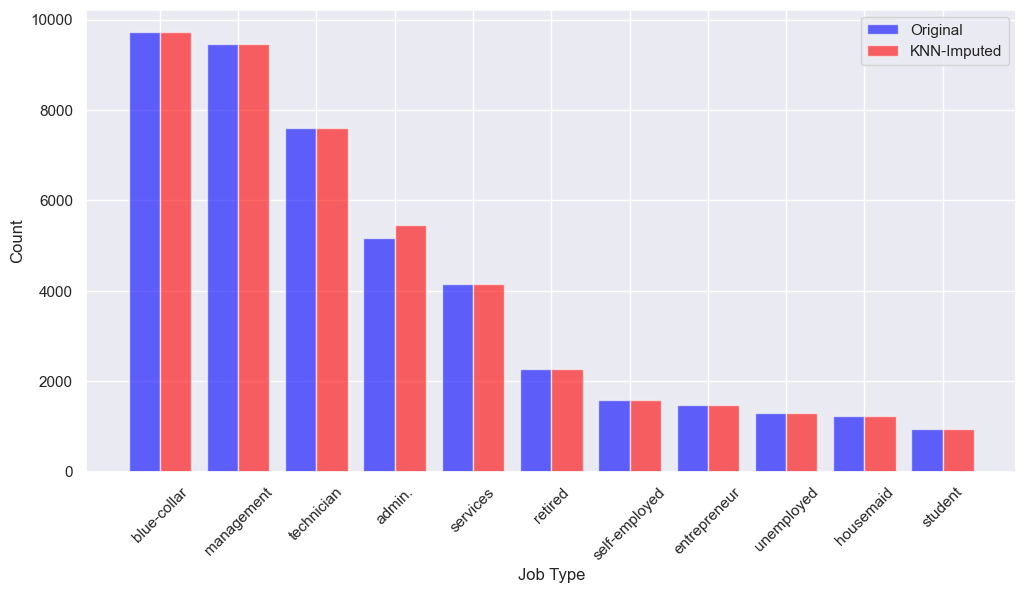

In [326]:
# Count occurrences of each job category
original_counts = df_to_impute["job"].value_counts()
imputed_counts = df_imputed_reversed["job"].value_counts()

# Create bar chart
plt.figure(figsize=(12, 6))
bar_width = 0.4  # Width of bars

# Positions for bars
index = np.arange(len(original_counts))

# Plot original and imputed data side by side
plt.bar(index, original_counts.values, bar_width, label="Original", color="blue", alpha=0.6)
plt.bar(index + bar_width, imputed_counts.values, bar_width, label="KNN-Imputed", color="red", alpha=0.6)

# Label the axes
plt.xlabel("Job Type")
plt.ylabel("Count")

# Set x-axis labels
plt.xticks(index + bar_width / 2, original_counts.index, rotation=45)

plt.legend()

plt.show()

ADD COMMENTARY

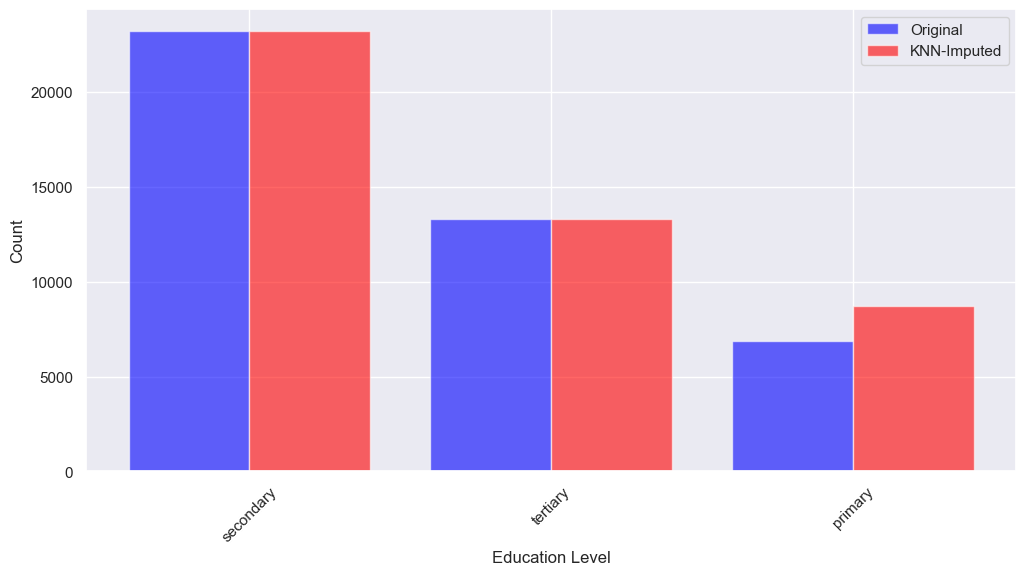

In [327]:
# Count occurrences of each education category
original_counts = df_to_impute["education"].value_counts()
imputed_counts = df_imputed_reversed["education"].value_counts()

# Create bar chart
plt.figure(figsize=(12, 6))
bar_width = 0.4  # Width of bars

# Positions for bars
index = np.arange(len(original_counts))

# Plot original and imputed data side by side
plt.bar(index, original_counts.values, bar_width, label="Original", color="blue", alpha=0.6)
plt.bar(index + bar_width, imputed_counts.values, bar_width, label="KNN-Imputed", color="red", alpha=0.6)

# Label the axes
plt.xlabel("Education Level")
plt.ylabel("Count")

# Set x-axis labels
plt.xticks(index + bar_width / 2, original_counts.index, rotation=45)

plt.legend()

plt.show()

ADD COMMENTARY

## Feature Engineering

### ever_contacted

While pdays is technically numeric, we cannot use it as a numeric variable when modeling. This is because anyone who was never contacted before the current marketing campaign received a pdays value of -1. This highly skews the distribution of pdays, as shown below.

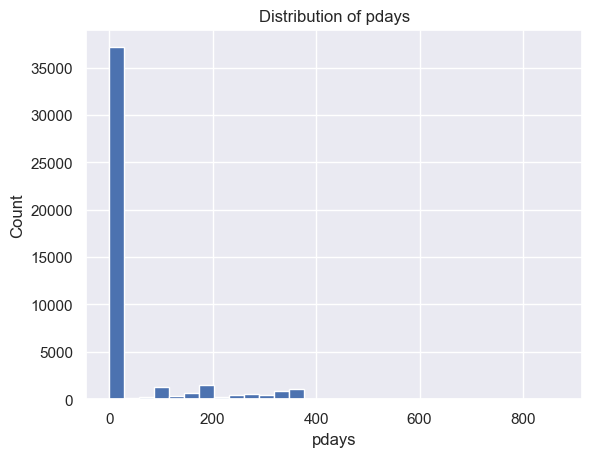

In [328]:
# Create a histogram to show the distribution of pdays
df_encoded.pdays.hist(bins=30)
plt.xlabel("pdays")
plt.ylabel("Count")
plt.title("Distribution of pdays")
plt.show()

To extract value out of this column, we will create a new binary variable called "ever_contacted" that is 1 if the customer has a pdays greater than -1, and 0 if pdays equals -1.

In [329]:
df_encoded["ever_contacted"] = df_encoded.pdays.apply(lambda x: 0 if x == -1 else 1)

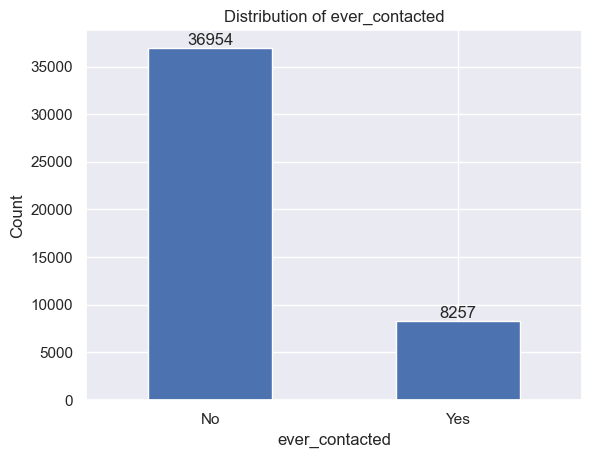

In [330]:
ax = df_encoded['ever_contacted'].value_counts().plot(kind='bar')
plt.xlabel('ever_contacted')
plt.ylabel('Count')
plt.title('Distribution of ever_contacted')

# Add count values to the top of the bars
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

plt.xticks([0, 1], ['No', 'Yes'], rotation=0)

plt.show()

Now we can see that only 8,257 customers were contacted during a previous marketing campaign. We could use this variable in future modeling efforts to examine the impact of previous contacts on the success of the current campaign.

### education_order

Because there is an inherant order to education (from less education to more educated), we want to create an ordinal variable called "education_order" that is 0 for only primary education, 1 for secondary education, and 2 for tertiary education.

In [331]:
le = LabelEncoder()
df_encoded["education_order"] = le.fit_transform(df_encoded["education"])

# Data Visualization

### Balance

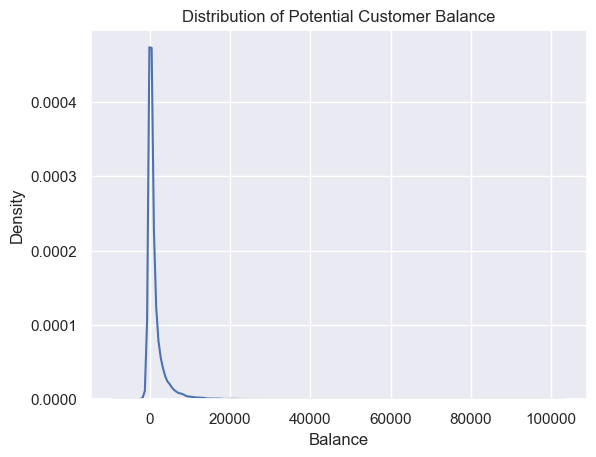

In [332]:
# Create a KDE plot for the balance column
ax = sns.kdeplot(df.balance)
ax.set_xlabel("Balance")
ax.set_title("Distribution of Potential Customer Balance")
plt.show()

ADD COMMENTARY

### Month

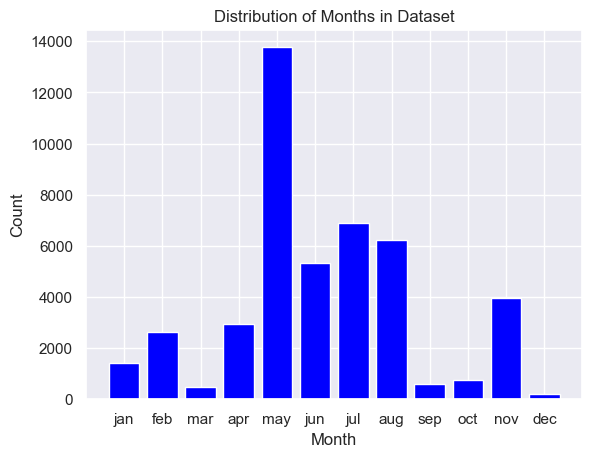

In [333]:
# Reorder the the month factor levels
month_order = ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]
month_counts = df['month'].value_counts()
month_counts = month_counts.reindex(month_order)
 
# Create a bar plot of the month counts
plt.bar(month_counts.index, month_counts.values, color="blue")
 
plt.xlabel("Month")
plt.ylabel("Count")
plt.title("Distribution of Months in Dataset")
 
plt.show()

This dataset consists of calls made primarily during the summer season, with activity dying down drastically after the month of August. This may not mean much to the bank or others, but they could put a bit of additional research into consumer psychology and they may discover which months customers are more likely to make large loan deposits. 

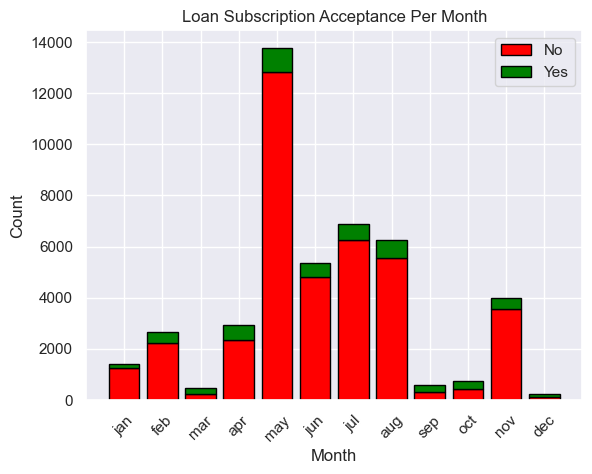

In [334]:
month_counts = df.groupby(['month', 'y']).size().unstack(fill_value=0)
month_counts = month_counts.reindex(month_order)
bar1 = plt.bar(month_counts.index, month_counts["no"], color="red", edgecolor="black", label="No")
bar2 = plt.bar(month_counts.index, month_counts["yes"], bottom=month_counts["no"], color="green", edgecolor="black", label="Yes")
plt.xlabel("Month")
plt.ylabel("Count")
plt.title("Loan Subscription Acceptance Per Month")
plt.xticks(rotation=45)
plt.legend()

plt.show()

Based on our findings, there is not a drastic difference in the percentage of acceptances per month. This means that the bank should not place a heavy emphasis on which months they are reaching out to their potential customers. 

### Education

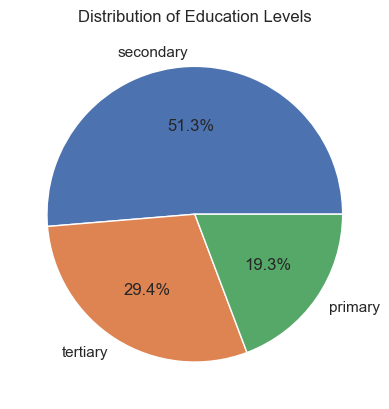

In [335]:
# Create a pie chart for the education column
education_counts = df_encoded['education'].value_counts()
 
plt.pie(education_counts.values, labels=education_counts.index, autopct='%1.1f%%')
plt.title("Distribution of Education Levels")
plt.show()

Our graph shows that the majority of potential customers are secondary school graduates (High School). Approximately 30% of potential customers have graduated tertiary school (University), and the remaining 20% have graduated at neither of these levels. It should be kept in mind that this data is from Portugal, and their education system may look drastically different than here in the United States. 

### Marital

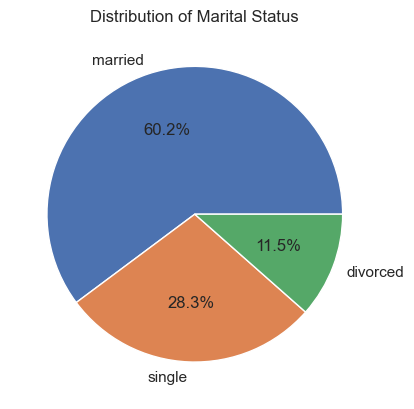

In [336]:
# Create a pie chart for the marital column
marital_counts = df['marital'].value_counts()
 
plt.pie(marital_counts.values, labels=marital_counts.index, autopct='%1.1f%%')
plt.title("Distribution of Marital Status")
plt.show()

The majority of customers in this dataset (60%) are married. Approximately 30% are single and the remaining number are divorced.

### Age

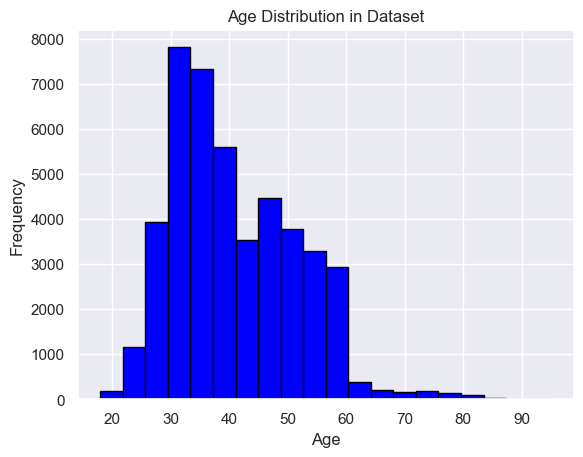

In [337]:
# Create a histogram for the age column
plt.hist(df['age'], bins=20, edgecolor='black', color='blue')

plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Age Distribution in Dataset")

plt.show()

The bulk of potential customers in this dataset are somewhere between their late 20s and early 30s. The bank likely targeted these people, as they may be seen as more likely to subscribe to a long term deposit. 

## Question 1: What is the correlation between features?

in order to answer the above question, we want to visualize the correlation between the different features

Note: in order to better compare the correlation, we temporally add two columns:'marital_num' and 'education_num', which have been applied label encoding.

In [338]:
label_features_temp = ['marital','education']
label_encoders_temp = {}
for col in label_features_temp:
    le = LabelEncoder()
    df_encoded[col+'_order'] = le.fit_transform(df_encoded[col])
    label_encoders_temp[col] = le

<Axes: >

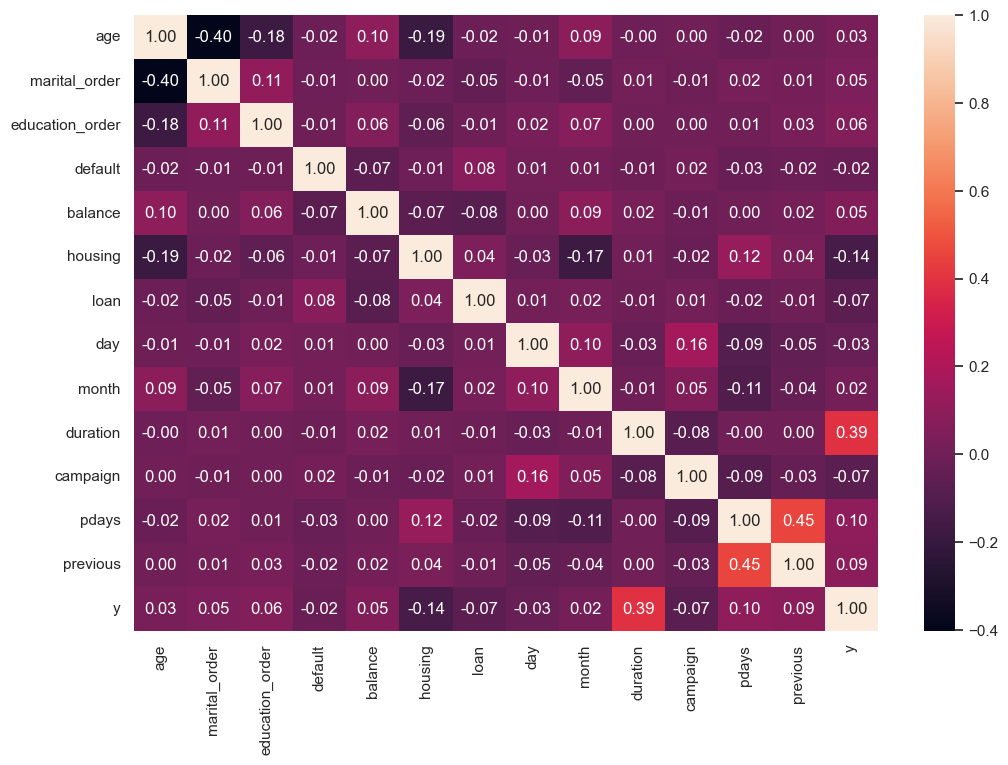

In [339]:
vars_to_use = ['age', 'marital_order', 'education_order', 'default', 'balance', 'housing', 'loan',
       'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'y']

cmap = sns.set(style="darkgrid")

f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df_encoded[vars_to_use].corr(), cmap=cmap, annot=True, fmt=".2f")

# f.tight_layout()

## Analysis
from the visualization, we can see that
1) 'previous' and 'pdays' have a high positive correlation(0.45), suggesting that the clients who are contacted frequently tends to be contact more recently.
2) 'duration' and 'y' have a high positive correlation(0.39), suggesting that the longer the call last, the more likely that clients are going to subscribe a term deposit. It is a good sign.
3) 'age' and 'marital_order' have a high negative correlation(-0.4), suggesting that marital yonger individuals tends to be single and older ones may have married and divorced.
4) some financial states such as default, housing, loan have a negative correlation with y, suggesting that clients that have financial problem are less likely to subscribe a term deposit. Additionally, 'balance' and 'y' have a positive correlation, meaning the person who have more average tends to subscribe. It is also a good sign.

## Question 2: How do financial states impact the subscription result (label)

In order to answer the above question, we want to visualize features including 'default', 'balance','housing' and 'loan' with 'y', and see how those features impact the subscribe rate.

First, lets visualize the balance distribution

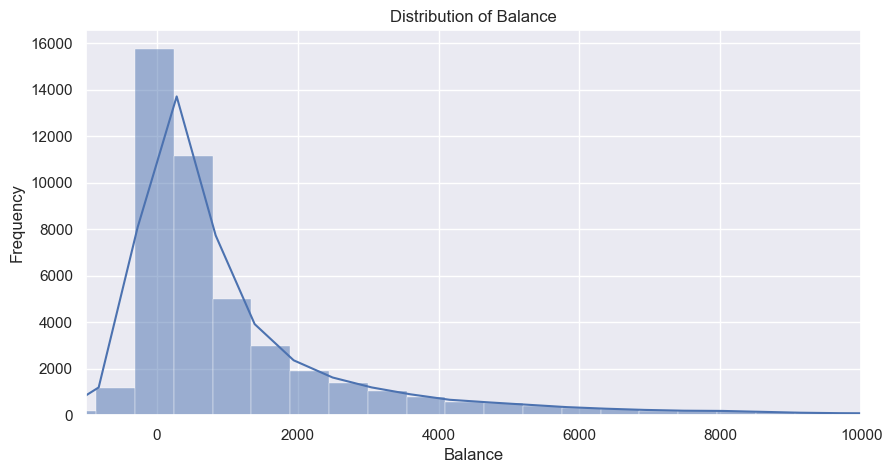

In [340]:
# Visualize balance distribution
plt.figure(figsize=(10,5))
sns.histplot(df_encoded['balance'], bins=200, kde=True)
plt.xlim(-1000, 10000)
plt.title("Distribution of Balance")
plt.xlabel("Balance")
plt.ylabel("Frequency")
plt.show()

Now let's create balance range. according to the visualziation above, we define ranges as follow:
- (negative infinite, 0)
- [0, 1000)
- [1000, 3000)
- [3000, 6000)
- [5000, infinite)

In [341]:
cut_values = [-float("inf"), 0,         1000,     3000,     6000,float("inf")]
cut_labels = ['negative balance','low balance','middle balance','high balance','very high balance']

df_encoded['balance_range'] = pd.cut(df_encoded['balance'],
                            cut_values,
                            labels=cut_labels)
df_encoded.balance_range.describe()

count           45211
unique              5
top       low balance
freq            23300
Name: balance_range, dtype: object

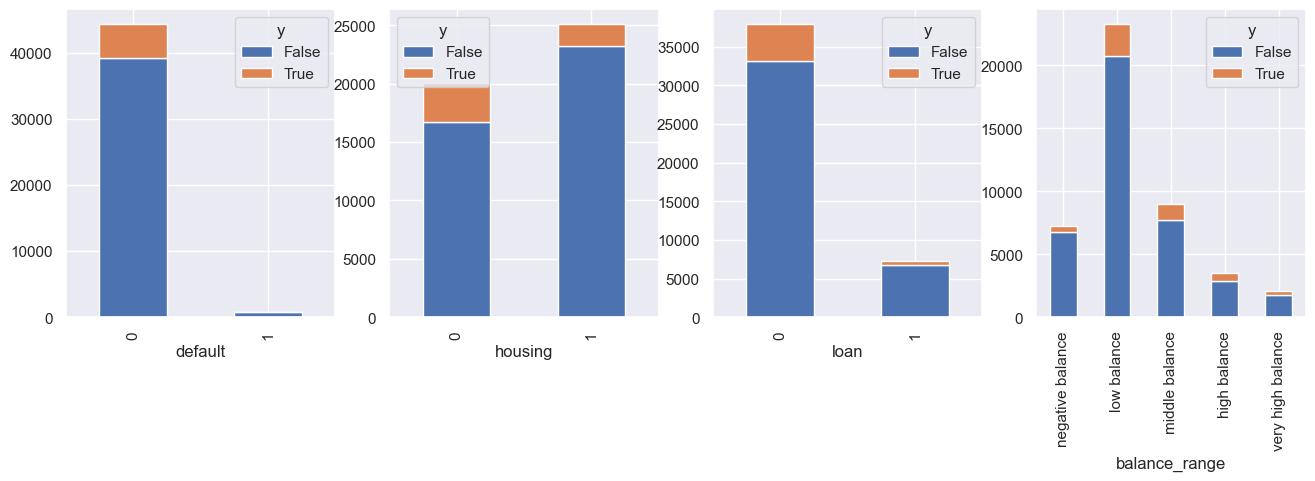

In [342]:
# plot overall cross tab with both groups
plt.figure(figsize=(16,4))
ax1 = plt.subplot(1,4,1)
ax2 = plt.subplot(1,4,2)
ax3 = plt.subplot(1,4,3)
ax4 = plt.subplot(1,4,4)

pd.crosstab([df_encoded['default']], # categories to cross tabulate
            df_encoded.y.astype(bool)).plot(kind='bar', stacked=True, ax=ax1)

pd.crosstab([df_encoded['housing']], # categories to cross tabulate
            df_encoded.y.astype(bool)).plot(kind='bar', stacked=True, ax=ax2)

pd.crosstab([df_encoded['loan']], # categories to cross tabulate
            df_encoded.y.astype(bool)).plot(kind='bar', stacked=True, ax=ax3)

pd.crosstab([df_encoded['balance_range']], # categories to cross tabulate
            df_encoded.y.astype(bool)).plot(kind='bar', stacked=True, ax=ax4)


plt.show()

### Analysis
From the visualization, we can see that
1. overall, the person who has financial problem, such as housing loan, credit in default, personal loan as well as low balance tends to have lower subscribe rate, suggesting individuals with financial problem are less likely to subscribe.
2. It seems that just very few individuals have credit in default, almost everyone  has no credit in default.
3. Majority of people have low yearly balance, and around 25% of individuals have negative balance but they are still willing to subscribe a term deposit.

## Question 3: How do duration ranges impact the subscription result(label)

In order to answer the above question, we want to visualize the correlation between duration range and subscribe rate
First, lets visualize the duration distribution

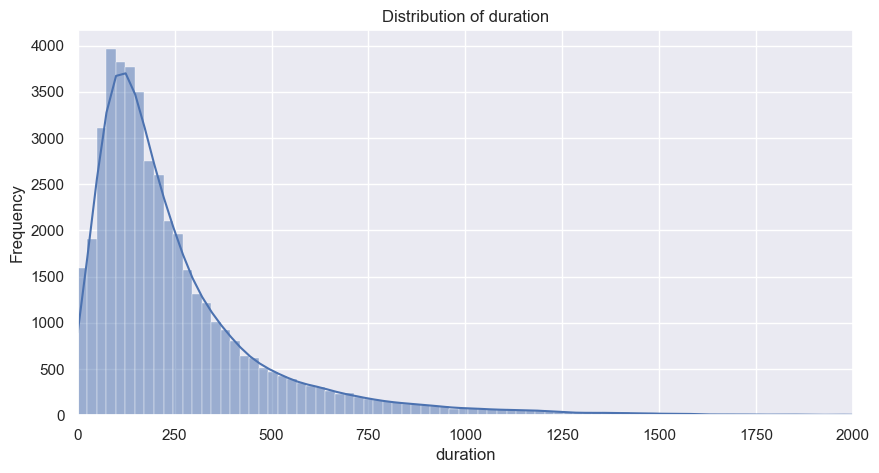

In [343]:
# Visualize balance distribution
plt.figure(figsize=(10,5))
sns.histplot(df_encoded['duration'], bins=200, kde=True)
plt.xlim(0, 2000)
plt.title("Distribution of duration")
plt.xlabel("duration")
plt.ylabel("Frequency")
plt.show()

Now let's create duration range. according to the visualziation above, we define ranges as follow:
- <100
- [100, 200)
- [200, 400)
- [400, 1000)
- 1000+

In [344]:
duration_bins = [0, 100, 200, 400, 1000, 100000]
duration_labels = ['<100', '100-200', '200-400', '400-1000','1000+']
df_encoded['duration_range'] = pd.cut(df_encoded['duration'], bins=duration_bins, labels=duration_labels)

<Figure size 800x400 with 0 Axes>

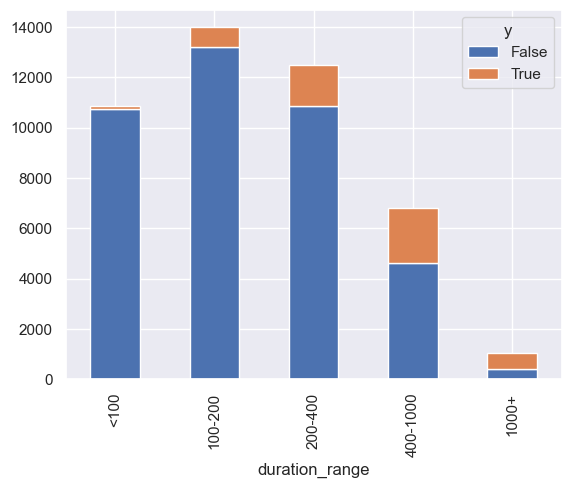

In [345]:
plt.figure(figsize=(8,4))
pd.crosstab([df_encoded['duration_range']], # categories to cross tabulate
            df_encoded.y.astype(bool)).plot(kind='bar', stacked=True)
plt.show()

### Analysis
From the visualization, we can see that
1. overall, the longer the call lasts, the more likely individuals are to subscribe
2. Although only a few calls last more than 1000 seconds, they do have a higher subscription rate. It suggests that individuals who are willing to stay on long calls may be highly interested and more likely to subscribe.
3. Even though the majority of calls last less than 100 seconds, only a few of them would choose to subscribe. It suggests that quick call may not works.
4. The 100-200s and 200-400s ranges contain the largest number of calls, and the subscription rate is higher compared to shorter calls.



## UMAP

In [346]:
# Create a dataframe with only numeric and boolean columns, removing columns that we had feature engineered alternatives for
umap_df = df_encoded.select_dtypes(include=['number', 'bool']).drop(
    columns=['month', 'pdays', 'marital_order', 'education_primary', 'education_secondary', 'education_tertiary'])

### Two Components

In [347]:
# Extract features and target
X = umap_df.drop(columns=['y'])
y = umap_df['y']

# Initialize UMAP to 2 dimensional display
umap_model = umap.UMAP(n_components=2)
X_umap = umap_model.fit_transform(X)

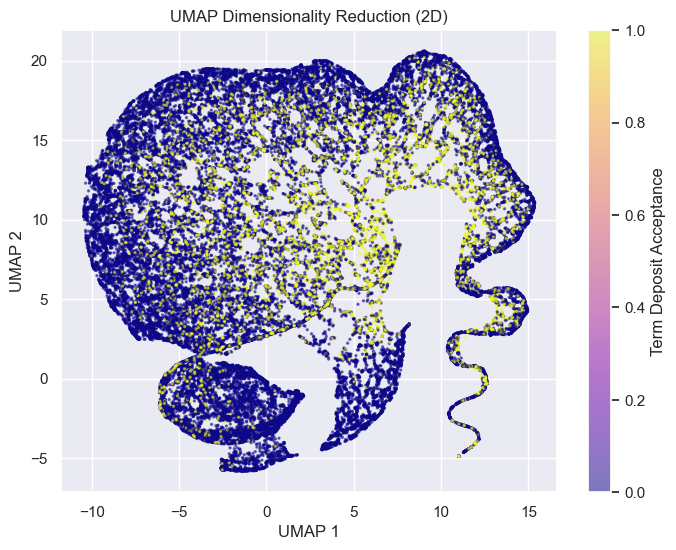

In [348]:
# Plot the 2D UMAP result
plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='plasma', s=2, alpha=0.5)
plt.colorbar(label='Term Deposit Acceptance')
plt.title('UMAP Dimensionality Reduction (2D)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

### Three Components

In [349]:
# Extract features and target
X = umap_df.drop(columns=['y'])
y = umap_df['y']

# Initialize UMAP to 3 dimensional display
umap_model = umap.UMAP(n_components=3)
X_umap = umap_model.fit_transform(X)

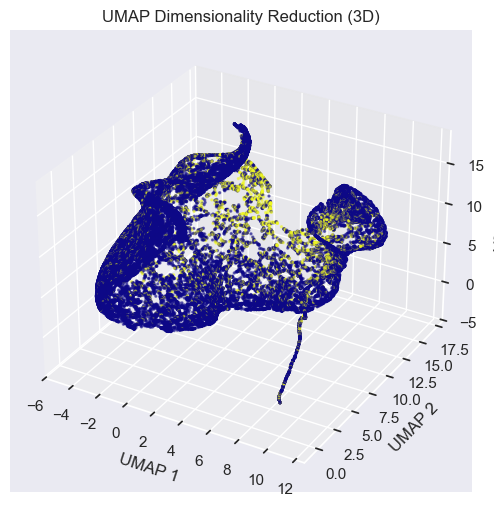

In [350]:
# Plot the 3D UMAP result
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(X_umap[:, 0], X_umap[:, 1], X_umap[:, 2], c=y, cmap='plasma', s=2, alpha=0.5)
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('UMAP 3')
ax.set_title('UMAP Dimensionality Reduction (3D)')
plt.show()

UMAP Analysis:
Initial thought - Based on our UMAP findings, there is not a clear and obvious separation between customers that accept/do not accept term deposit subscriptions. On both the 2D and 3D UMAP depictions, the yellow (accept) and blue (do not accept) dots are intertwined along the entire path that the dots take. This means that there is not any one or two variables that determine whether or not people will subscribe to a term deposit. Based on that information, banks will just have to stay persistent on contacting potential customers of all backgrounds, education levels, and marital status, etc. going forward.

(Update - we notice that the edges of the graph patterns on our grids are almost all blue dots, while yellow dots are taking up the middle of the pattern. Not exactly sure what this means, but this could mean that these types of customers are the ones the banks should be targeting. This could hint at the fact that customers that accept the term deposits do follow some sort of pattern (homogeneous), while the outer blue shell consists of more heterogeneous data (scattered). This idea can be tested further through implementation of regression analysis, but we are not to that stage quite yet.)

## References

UC Irvine. (2012, February 13). Bank marketing. *UCI Machine Learning Repository*. https://archive.ics.uci.edu/dataset/222/bank+marketing 

Moro, S., Cortez, P., & Rita, P. (2014). A data-driven approach to predict the success of bank telemarketing. *Decision Support Systems*, 62, 22-31.

Yamahata, H. (2020, July 10). Bank Marketing + Classification + roc,f1,recall... Kaggle. https://www.kaggle.com/code/henriqueyamahata/bank-marketing-classification-roc-f1-recall 